# EECS 598 Generative Adversarial Networks tutorial
(Based on tutorial from: http://cs231n.stanford.edu/)

<img src="gan.png"/>

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:

$$
\begin{equation}
\underset{G}{\text{min}}\; \underset{D}{\text{max}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)} \left[\log \left(1-D(G(z))\right)\right]
\end{equation}
$$

where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**:

$$
\begin{equation}
\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]
\end{equation}
$$

This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661).


Given the previous definitions, let us implement Generative Adversarial Networks:

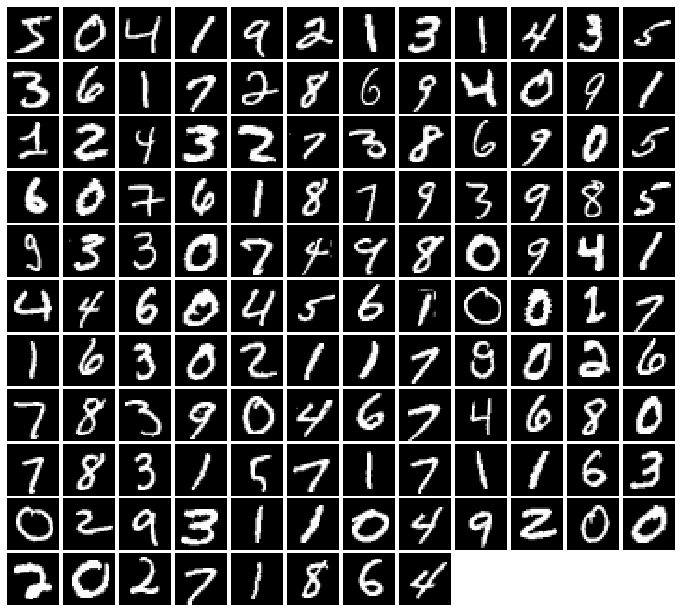

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

dtype = torch.FloatTensor
#dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

# Set up loss
criterion = torch.nn.BCEWithLogitsLoss()

mnist_train = dset.MNIST('./data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


To generate data with GANs, we start from a random noise vector that will be fed to the generator in order to genrate data:

In [2]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    
    ###########################
    ######### TO DO ###########
    ###########################
    noise = None
    noise = torch.FloatTensor(batch_size, dim).uniform_(-1, 1)
    return noise

In [3]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')
    
test_sample_noise()

All tests passed!


Let us now build the discriminator network:

In [4]:
def discriminator():
    """
    Build and return a PyTorch model for the discriminator
    using the architecture described below:

    * Fully connected layer with input size 784 and output size 512
    * LeakyReLU with alpha 0.01
    * Fully connected layer with input_size 512 and output size 512
    * LeakyReLU with alpha 0.01
    * Fully connected layer with input size 512 and output size 1

    Note: Make sure the input is flattened
          (i.e., use the given Flatten() function)
    """
    return nn.Sequential(
        ###########################
        ######### TO DO ###########
        ###########################
        Flatten(),
        nn.Linear(784, 512),
        nn.LeakyReLU(inplace=True),
        nn.Linear(512,512),
        nn.LeakyReLU(inplace=True),
        nn.Linear(512,1)
    )

Test the discriminator network output shape is correct:

In [5]:
dummy_logits = discriminator()(torch.zeros(1, 28, 28, 1))
assert list(dummy_logits.shape) == [1, 1]
print('Discriminator passes successfully!')

Discriminator passes successfully!


Now, let us build a generator network:

In [6]:
def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described below:

    * Fully connected layer from noise_dim to 1024
    * `ReLU`
    * Fully connected layer with size 1024 
    * `ReLU`
    * Fully connected layer with size 784
    * `TanH` (to clip the image to be in the range of [-1,1])
    """
    return nn.Sequential(
        ###########################
        ######### TO DO ###########
        ###########################
        nn.Linear(noise_dim,1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024,1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024,784),
        nn.Tanh()
    )

Test the discriminator network output shape is correct:

In [7]:
dummy_image = generator()(torch.zeros(1, NOISE_DIM))
assert list(dummy_image.shape) == [1, 784]
print('Generator passed successfully!')

Generator passed successfully!


Below, we implement the discriminator and generators loss described above:

In [8]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    N, _ = logits_real.size()
    true_label = torch.ones(N, 1).type(dtype)
    fake_label = torch.zeros(N, 1).type(dtype)
    real_loss = criterion(logits_real, true_label)
    fake_loss = criterion(logits_fake, fake_label)
    loss = real_loss + fake_loss
    return loss

In [9]:
def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    N, _ = logits_fake.size()
    true_label = torch.ones(N, 1).type(dtype)
    g_loss = criterion(logits_fake, true_label)
    return g_loss

Finally, we set up an optimizer to train our GAN:

In [10]:
def get_optimizer(model):
    """
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr = 1e-3, betas = (0.5,0.999))
    return optimizer

# Training a GAN!

We provide you the main training loop... you won't need to change this function, but we encourage you to read through and understand it. 

In [11]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=15):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

Iter: 0, D: 1.389, G:0.7004


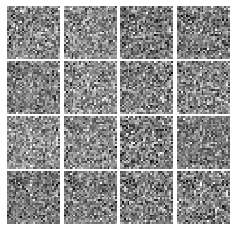


Iter: 250, D: 0.9542, G:1.334


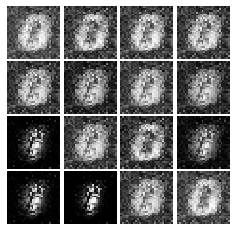


Iter: 500, D: 0.9951, G:1.047


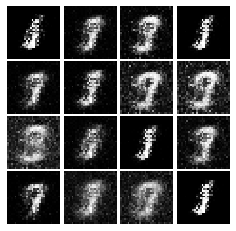


Iter: 750, D: 1.19, G:1.077


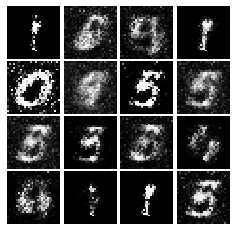


Iter: 1000, D: 1.119, G:1.214


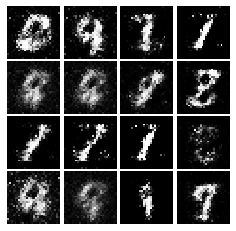


Iter: 1250, D: 1.111, G:0.8821


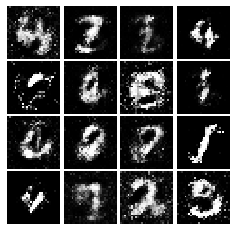


Iter: 1500, D: 1.177, G:1.009


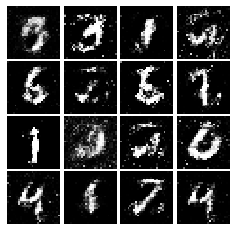


Iter: 1750, D: 1.733, G:1.637


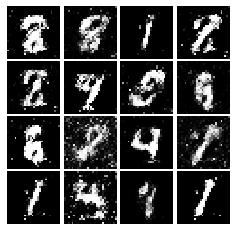


Iter: 2000, D: 1.345, G:1.1


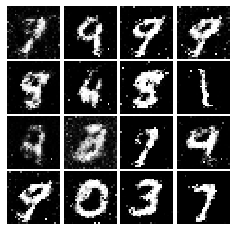


Iter: 2250, D: 1.226, G:1.033


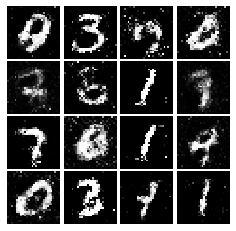


Iter: 2500, D: 1.211, G:1.027


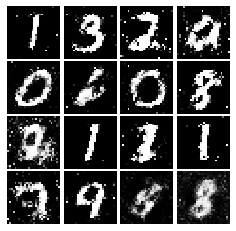


Iter: 2750, D: 1.234, G:0.9403


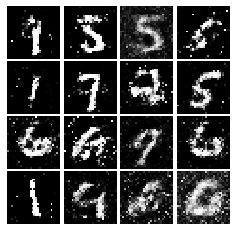


Iter: 3000, D: 1.273, G:0.8205


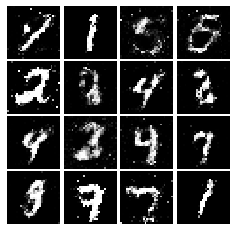


Iter: 3250, D: 1.228, G:0.9686


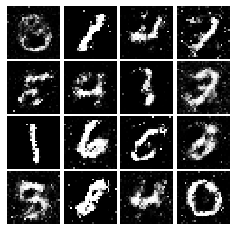


Iter: 3500, D: 1.255, G:0.8329


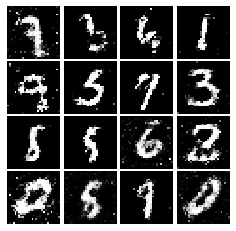


Iter: 3750, D: 1.266, G:0.8152


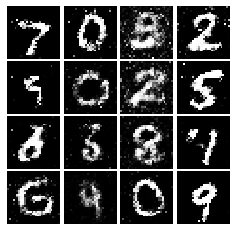


Iter: 4000, D: 1.339, G:0.7789


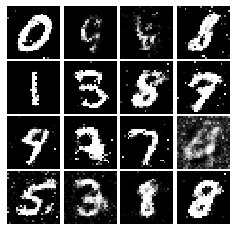


Iter: 4250, D: 1.285, G:0.9095


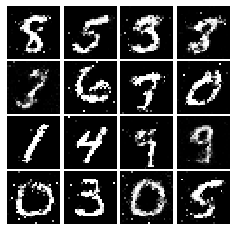


Iter: 4500, D: 1.294, G:0.8855


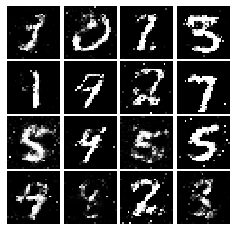


Iter: 4750, D: 1.326, G:0.9115


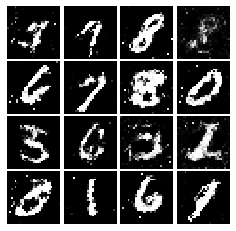


Iter: 5000, D: 1.194, G:1.051


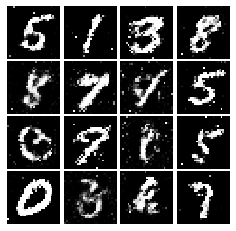


Iter: 5250, D: 1.301, G:0.875


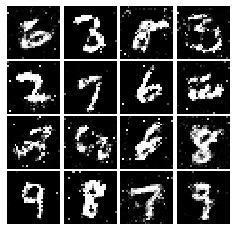


Iter: 5500, D: 1.292, G:0.7908


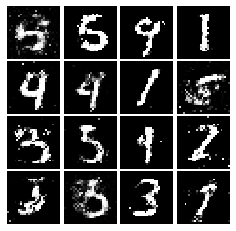


Iter: 5750, D: 1.28, G:0.8404


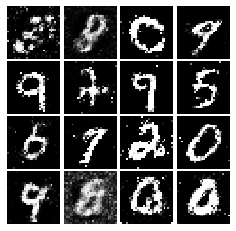

In [12]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)